# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.checkTD3 import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *
from src.solidStuffManagement import *

In [2]:
#FLUID PARAMETERS 
e = 0.5 #half width in meters
U = 1 # Upper bound velocity
Re = 1 # Reynolds number
#FLUID PARAMETERS
rhoF = 1000
mu = rhoF*U*e/Re #(Pa.s)
grav = np.array([0.0,-9.81])#np.array([0.0,-9.81])#np.array([0.0,0.0]) #m.s-2#OTHER FLUID PARAMETERS
c0 = 10*U
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF


In [3]:
#GEOMETRY
Lx = 2
Ly = 2
lx = 0.5
ly=1
#PARTICLES & SPACES PARAMETERS : 
dr = ly/20
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
#SOLID PARAMETERS
ls = 0.4
ws = 0.2
rhoS = 500
ms = dr*dr*rhoS 
#COMPUTATION DOMAIN : 
xOrigin = -nBound*dr
yOrigin = -nBound*dr
xSize = Lx+2*nBound*dr
ySize = Ly+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize
#INIT SPACES & PART:
posSpace,neibSpace,partSpace,listNeibSpace = \
init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
part = init_particles()

In [4]:
#INIT PART:
#% COMPLETE HERE
part = addBox(part,[Lx,Ly/2],FLUID,dr,rhoF)
part = addBox(part,[-nBound*dr,-nBound*dr,Lx+2*nBound*dr,nBound*dr],BOUND,dr,rhoF)
part = addBox(part,[-nBound*dr,0,nBound*dr,Ly],BOUND,dr,rhoF)
part = addBox(part,[Lx,0,nBound*dr,Ly],BOUND,dr,rhoF)
numberOfNonSolidParticles = len(part)
part = addBox(part,[(Lx-ws)/2, (Ly-ls), ws, ls], MOBILESOLID, dr, rhoS)
part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
numberOfSolidPart = len(part)-numberOfNonSolidParticles
# END

<IPython.core.display.Javascript object>


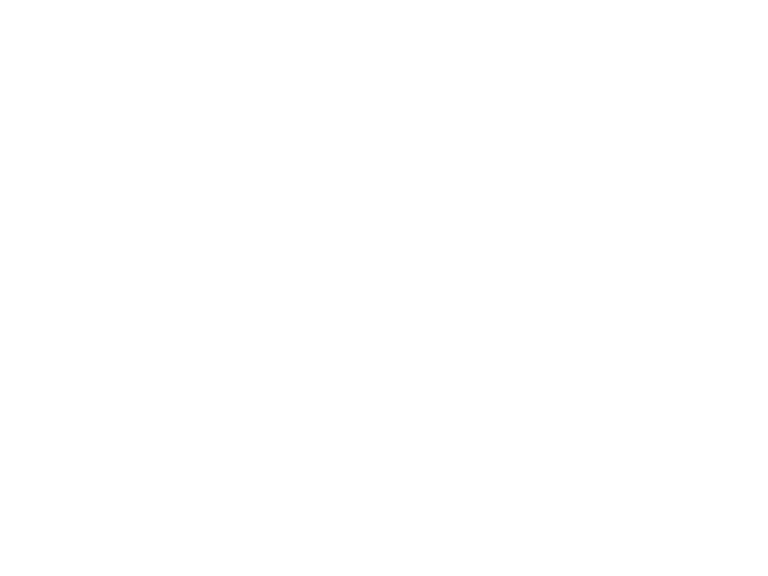

In [5]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

In [6]:
plotSpaces(posSpace,'k',lspace,1)
neibSpace[2][neibSpace[2]>-1]
spacesOutline(posSpace[neibSpace[2][neibSpace[2]>-1]],'r',lspace,1)

Initialisation de la pression

In [7]:
def initWaterPressure(part):
    infoTab = part[:,INFO]
    y_i = part[infoTab == FLUID] [:,POS[1]]
    p_i = np.linalg.norm(grav)*rhoF*(Ly/2-y_i)
    rho_i = density(p_i,B,rhoF,gamma)
    part[infoTab == FLUID, RHO] = rho_i
    return part

<IPython.core.display.Javascript object>


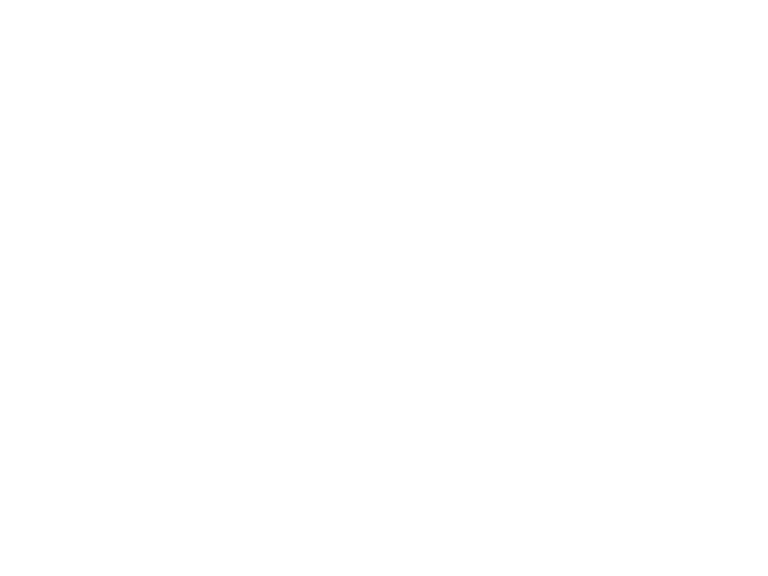

In [8]:
part = initWaterPressure(part)
%matplotlib notebook
Pmax= rhoF*np.linalg.norm(grav)*Ly/2
tabPres = pressure(part[:,RHO],B,rhoF,gamma)
domain = [xOrigin,xMax,yOrigin,yMax,0,Pmax]
plotPropertiesWithBound(part,tabPres,r'Pressure',domain,dr,1)

In [9]:
#Managing the center of mass
#OG = computeCenterOfMass(part, numberOfSolidPart)
infoTab = part[:,INFO]
OG = np.array([1/numberOfSolidPart*np.sum(part[infoTab == MOBILESOLID] [:,POS[0]]),1/numberOfSolidPart*np.sum(part[infoTab == MOBILESOLID] [:,POS[1]])])
print(OG)
V_OG = np.array([0,0])

[1.  1.8]


In [10]:
current_directory = os.getcwd()
case_directory = os.path.join(current_directory, r'Results/Floating_solid_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

In [11]:
# Here we specify the output frequencies
dt_figure = 0.025*e**2*rhoF/mu
t_print = 0
#final time :
t_end = 3
t=0
it=0
im_count=0

[ 0.00e+00 -9.81e-06] [ 0.      -0.00981]


<IPython.core.display.Javascript object>


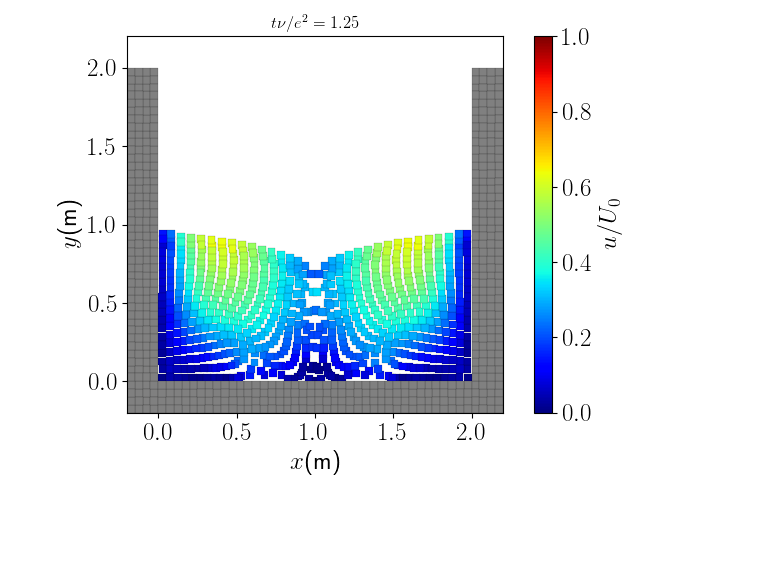

[ 0.00000000e+00 -1.95911669e-05] [ 0.         -0.01961039]
[ 0.00000000e+00 -2.92672347e-05] [ 0.         -0.02938205]
[ 0.00000000e+00 -3.88586292e-05] [ 0.         -0.03912521]
[ 0.0000000e+00 -4.8366654e-05] [ 0.         -0.04884011]
[ 0.00000000e+00 -5.77925126e-05] [ 0.       -0.058527]
[ 0.00000000e+00 -6.71373839e-05] [ 0.         -0.06818612]
[ 0.00000000e+00 -7.64024233e-05] [ 0.        -0.0778177]
[ 0.00000000e+00 -8.55887634e-05] [ 0.         -0.08742199]
[ 0.00000000e+00 -9.46975141e-05] [ 0.         -0.09699921]
[ 0.         -0.00010373] [ 0.         -0.10654959]
[ 0.         -0.00011269] [ 0.         -0.11607335]
[ 0.         -0.00012157] [ 0.         -0.12557072]
[ 0.         -0.00013038] [ 0.         -0.13504192]
[ 0.         -0.00013911] [ 0.         -0.14448716]
[ 0.         -0.00014778] [ 0.         -0.15390666]
[ 0.         -0.00015638] [ 0.         -0.16330062]
[ 0.        -0.0001649] [ 0.         -0.17266925]
[ 0.         -0.00017336] [ 0.         -0.18201276]
[ 

[ 0.         -0.00095583] [ 0.         -1.33539076]
[ 0.        -0.0009594] [ 0.         -1.34240185]
[ 0.         -0.00096295] [ 0.        -1.3494024]
[ 0.         -0.00096649] [ 0.         -1.35639246]
[ 0.         -0.00097001] [ 0.         -1.36337209]
[ 0.         -0.00097352] [ 0.         -1.37034132]
[ 0.         -0.00097701] [ 0.        -1.3773002]
[ 0.         -0.00098049] [ 0.         -1.38424879]
[ 0.         -0.00098395] [ 0.         -1.39118712]
[ 0.         -0.00098739] [ 0.         -1.39811524]
[ 0.         -0.00099082] [ 0.        -1.4050332]
[ 0.         -0.00099424] [ 0.         -1.41194103]
[ 0.         -0.00099764] [ 0.         -1.41883879]
[ 0.         -0.00100102] [ 0.         -1.42572652]
[ 0.         -0.00100439] [ 0.         -1.43260426]
[ 0.         -0.00100775] [ 0.         -1.43947206]
[ 0.         -0.00101109] [ 0.         -1.44632995]
[ 0.         -0.00101442] [ 0.         -1.45317799]
[ 0.         -0.00101773] [ 0.         -1.46001621]
[ 0.         -0.0010

[ 0.         -0.00138974] [ 0.         -2.37660351]
[ 0.         -0.00139169] [ 0.        -2.3823342]
[ 0.         -0.00139363] [ 0.         -2.38805915]
[ 0.         -0.00139557] [ 0.         -2.39377835]
[ 0.        -0.0013975] [ 0.         -2.39949184]
[ 0.         -0.00139943] [ 0.         -2.40519963]
[ 0.         -0.00140135] [ 0.         -2.41090173]
[ 0.         -0.00140326] [ 0.         -2.41659816]
[ 0.         -0.00140517] [ 0.         -2.42228895]
[ 0.         -0.00140707] [ 0.         -2.42797409]
[ 0.         -0.00140897] [ 0.         -2.43365363]
[ 0.         -0.00141086] [ 0.         -2.43932756]
[ 0.         -0.00141275] [ 0.        -2.4449959]
[ 0.         -0.00141463] [ 0.         -2.45065868]
[ 0.         -0.00141651] [ 0.         -2.45631591]
[ 0.         -0.00141838] [ 0.        -2.4619676]
[ 0.         -0.00142024] [ 0.         -2.46761377]
[ 0.        -0.0014221] [ 0.         -2.47325444]
[ 0.         -0.00142396] [ 0.         -2.47888963]
[ 0.        -0.0014258

[-3.00880694e-18 -3.38153072e-03] [-2.25684179e-14 -2.53641394e+01]
[-3.17811377e-18 -3.41842548e-03] [-2.59034607e-14 -2.78621399e+01]
[-3.34972216e-18 -3.45171163e-03] [-2.96753288e-14 -3.05788579e+01]
[-3.53078453e-18 -3.48155578e-03] [-3.40025628e-14 -3.35284745e+01]
[-3.66386124e-18 -3.50809318e-03] [-3.83555675e-14 -3.67248910e+01]
[-3.83498418e-18 -3.53145665e-03] [-4.36351556e-14 -4.01815635e+01]
[-4.04900992e-18 -3.55180052e-03] [-5.00584545e-14 -4.39113878e+01]
[-4.21542416e-18 -3.56935456e-03] [-5.66024034e-14 -4.79273352e+01]
[-4.43563449e-18 -3.58448078e-03] [-6.46494218e-14 -5.22438470e+01]
[-4.64820171e-18 -3.59755031e-03] [-7.34873799e-14 -5.68767370e+01]
[-4.84826088e-18 -3.60883824e-03] [-8.30819467e-14 -6.18426511e+01]
[-5.05763364e-18 -3.61855186e-03] [-9.38677205e-14 -6.71589204e+01]
[-5.31623672e-18 -3.62686091e-03] [-1.06773543e-13 -7.28434060e+01]
[-5.54445760e-18 -3.63387894e-03] [-1.20404132e-13 -7.89137681e+01]
[-5.77310678e-18 -3.63969083e-03] [-1.35437420e-

[ 5.23847233e-18 -5.20669778e-03] [ 1.41524702e-12 -1.40666268e+03]
[ 5.32512507e-18 -5.20557324e-03] [ 1.48171519e-12 -1.44844991e+03]
[ 5.52249358e-18 -5.20529372e-03] [ 1.58225659e-12 -1.49137526e+03]
[ 6.60492323e-18 -5.20578446e-03] [ 1.94833688e-12 -1.53561540e+03]
[ 4.10989359e-18 -5.20361040e-03] [ 1.24817085e-12 -1.58033162e+03]
[ 5.51158434e-18 -5.19922626e-03] [ 1.72289207e-12 -1.62525059e+03]
[ 5.70322581e-18 -5.19478443e-03] [ 1.83391914e-12 -1.67042564e+03]
[ 5.59791256e-18 -5.19120612e-03] [ 1.85048864e-12 -1.71604466e+03]
[ 5.3612387e-18 -5.1884494e-03] [ 1.82092880e-12 -1.76224143e+03]
[ 4.98474846e-18 -5.18629525e-03] [ 1.73882287e-12 -1.80912816e+03]
[ 4.42035957e-18 -5.18497730e-03] [ 1.58309414e-12 -1.85693200e+03]
[ 3.46606034e-18 -5.18443412e-03] [ 1.27414463e-12 -1.90582917e+03]
[ 1.20117975e-18 -5.18466529e-03] [ 4.53176434e-13 -1.95605039e+03]
[ 1.31738147e-18 -5.18487311e-03] [ 5.10074238e-13 -2.00752042e+03]
[-9.95931033e-19 -5.18159977e-03] [-3.95740249e-13

[ 9.30193481e-19 -5.08901274e-03] [ 1.02069338e-12 -5.58413032e+03]
[ 7.58813441e-19 -5.08882668e-03] [ 8.43015686e-13 -5.65351175e+03]
[ 9.36902377e-18 -5.08653820e-03] [ 1.05379426e-11 -5.72115611e+03]
[ 1.13581061e-17 -5.08683224e-03] [ 1.29308266e-11 -5.79118955e+03]
[ 1.17325632e-17 -5.08593204e-03] [ 1.35186649e-11 -5.86018669e+03]
[ 1.18486239e-17 -5.08387638e-03] [ 1.38171261e-11 -5.92849953e+03]
[ 1.18438491e-17 -5.08227165e-03] [ 1.39741859e-11 -5.99641285e+03]
[ 1.17610174e-17 -5.08100210e-03] [ 1.40366712e-11 -6.06413148e+03]
[ 1.15872746e-17 -5.08007159e-03] [ 1.39864712e-11 -6.13192293e+03]
[ 1.13052981e-17 -5.07943626e-03] [ 1.37993084e-11 -6.19998754e+03]
[ 1.08487308e-17 -5.07909732e-03] [ 1.33894064e-11 -6.26857644e+03]
[ 9.87277931e-18 -5.07913121e-03] [ 1.23198108e-11 -6.33802638e+03]
[ 6.00543149e-18 -5.07755558e-03] [ 7.57681439e-12 -6.40615020e+03]
[ 7.69755369e-18 -5.07739161e-03] [ 9.81759590e-12 -6.47579492e+03]
[ 8.21420192e-18 -5.07641416e-03] [ 1.05897040e-

[-3.76913839e-18 -5.04727855e-03] [-7.84303095e-12 -1.05026554e+04]
[-3.61004047e-18 -5.04661999e-03] [-7.56168348e-12 -1.05707798e+04]
[-3.52094455e-18 -5.04584485e-03] [-7.42336066e-12 -1.06383743e+04]
[-3.46826130e-18 -5.04534389e-03] [-7.35935711e-12 -1.07057930e+04]
[-3.44353286e-18 -5.04504162e-03] [-7.35337768e-12 -1.07732663e+04]
[-3.43169032e-18 -5.04492918e-03] [-7.37437967e-12 -1.08410782e+04]
[-3.4320139e-18 -5.0450248e-03] [-7.42150508e-12 -1.09095354e+04]
[-3.43863722e-18 -5.04533862e-03] [-7.48268560e-12 -1.09789664e+04]
[-3.30748296e-18 -5.04591956e-03] [-7.24289217e-12 -1.10498079e+04]
[-1.12367957e-17 -5.04578963e-03] [-2.47645204e-11 -1.11203019e+04]
[-1.07177604e-17 -5.04590923e-03] [-2.37721103e-11 -1.11918821e+04]
[-1.04996499e-17 -5.04574676e-03] [-2.34375116e-11 -1.12632087e+04]
[-1.03592871e-17 -5.04546067e-03] [-2.32722325e-11 -1.13346732e+04]
[-1.02521766e-17 -5.04541007e-03] [-2.31779999e-11 -1.14066035e+04]
[-1.01587914e-17 -5.04556834e-03] [-2.31125474e-11

[-1.11033600e-17 -5.03900551e-03] [-3.72598827e-11 -1.69095439e+04]
[-1.11276111e-17 -5.03854226e-03] [-3.75431819e-11 -1.69994176e+04]
4 particles are deleted because outside computational domain
[-1.10917131e-17 -5.03501372e-03] [-3.76219388e-11 -1.70782437e+04]
[-1.10156945e-17 -5.03339652e-03] [-3.75499264e-11 -1.71576715e+04]
[-1.08788767e-17 -5.03357479e-03] [-3.72557090e-11 -1.72379375e+04]
[-1.06256528e-17 -5.03388164e-03] [-3.65582056e-11 -1.73193764e+04]
[-1.00082865e-17 -5.03436478e-03] [-3.45959582e-11 -1.74024468e+04]
[-6.17908372e-18 -5.03475345e-03] [-2.14610843e-11 -1.74866166e+04]
[-6.59683770e-18 -5.03424419e-03] [-2.30223457e-11 -1.75690407e+04]
[-6.77122161e-18 -5.03342737e-03] [-2.37437337e-11 -1.76500439e+04]
[-6.85459989e-18 -5.03278120e-03] [-2.41481280e-11 -1.77300275e+04]
[-6.88808663e-18 -5.03227648e-03] [-2.43769878e-11 -1.78092624e+04]
4 particles are deleted because outside computational domain
[-6.87420817e-18 -5.02879163e-03] [-2.44373219e-11 -1.78769971

[-4.95358418e-15 -2.88746735e+00] [-3.33453616e-11 -1.94371670e+04]
[-4.98679752e-15 -2.90682778e+00] [-3.33453616e-11 -1.94371684e+04]
[-5.02020972e-15 -2.92630413e+00] [-3.33453616e-11 -1.94371699e+04]
[-5.05379354e-15 -2.94588052e+00] [-3.33453616e-11 -1.94371714e+04]
[-5.08752342e-15 -2.96554206e+00] [-3.33453616e-11 -1.94371729e+04]
[-5.12137601e-15 -2.98527513e+00] [-3.33453616e-11 -1.94371744e+04]
[-5.15532949e-15 -3.00506701e+00] [-3.33453616e-11 -1.94371759e+04]
[-5.18936546e-15 -3.02490698e+00] [-3.33453616e-11 -1.94371775e+04]
[-5.22346854e-15 -3.04478608e+00] [-3.33453616e-11 -1.94371790e+04]
[-5.25762538e-15 -3.06469652e+00] [-3.33453616e-11 -1.94371805e+04]
[-5.29182356e-15 -3.08463106e+00] [-3.33453616e-11 -1.94371821e+04]
[-5.32605060e-15 -3.10458242e+00] [-3.33453616e-11 -1.94371837e+04]
[-5.36029402e-15 -3.12454335e+00] [-3.33453616e-11 -1.94371852e+04]
[-5.39454139e-15 -3.14450657e+00] [-3.33453616e-11 -1.94371868e+04]
[-5.42878099e-15 -3.16446527e+00] [-3.33453616e-

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-6.61015238e-15 -3.85310563e+00] [-3.33453616e-11 -1.94372525e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-6.64074222e-15 -3.87093706e+00] [-3.33453616e-11 -1.94372544e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-6.67121206e-15 -3.88869854e+00] [-3.33453616e-11 -1.94372564e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-6.70156528e-15 -3.90639205e+00] [-3.33453616e-11 -1.94372584e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-6.73180545e-15 -3.92401967e+00] [-3.33453616e-11 -1.94372603e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-6.76193607e-15 -3.94158344e+00] [-3.33453616e-11 -1.94372623e+04]
2 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpac

[-7.77768523e-15 -4.53368670e+00] [-3.33453616e-11 -1.94373285e+04]
2 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-7.82889095e-15 -4.56353554e+00] [-3.33453616e-11 -1.94373308e+04]
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-7.88419415e-15 -4.59577285e+00] [-3.33453616e-11 -1.94373331e+04]
2 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-7.94562022e-15 -4.63157926e+00] [-3.33453616e-11 -1.94373354e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-8.01212274e-15 -4.67034479e+00] [-3.33453616e-11 -1.94373378e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-8.08700881e-15 -4.71399719e+00] [-3.33453616e-11 -1.94373402e+04]
ATTENTION : too man

[-1.26466218e-14 -7.37187170e+00] [-3.33453616e-11 -1.94374223e+04]
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.28788982e-14 -7.50726994e+00] [-3.33453616e-11 -1.94374261e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.31315248e-14 -7.65453070e+00] [-3.33453616e-11 -1.94374299e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.34183595e-14 -7.82173182e+00] [-3.33453616e-11 -1.94374339e+04]
2 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.37276381e-14 -8.00201589e+00] [-3.33453616e-11 -1.94374379e+04]
2 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.40864798e-14 -8.21119105e+00] [-3.33453616e-11 -1.94374421e+04]
ATTENTION : too man

[-1.84093517e-14 -1.07311576e+01] [-3.33453616e-11 -1.94376390e+04]
2 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.84701330e-14 -1.07665913e+01] [-3.33453616e-11 -1.94376445e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.85337991e-14 -1.08037064e+01] [-3.33453616e-11 -1.94376499e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.85972211e-14 -1.08406794e+01] [-3.33453616e-11 -1.94376554e+04]
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.86612389e-14 -1.08779997e+01] [-3.33453616e-11 -1.94376609e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-1.87245802e-14 -1.09149256e+01] [-3.33453616e-11 -1.94376664e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-

[-2.51851101e-14 -1.46810998e+01] [-3.33453616e-11 -1.94379369e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.53751319e-14 -1.47918744e+01] [-3.33453616e-11 -1.94379443e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.54467341e-14 -1.48336190e+01] [-3.33453616e-11 -1.94379518e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.55068295e-14 -1.48686561e+01] [-3.33453616e-11 -1.94379593e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.55697688e-14 -1.49053510e+01] [-3.33453616e-11 -1.94379669e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.56361096e-14 -1.49440287e+01] [-3.33453616e-11 -1.94379744e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.57056833e-14 -1.49845911e+01] [-3.33453616e-11 -1.94379820e+04]
ATTENTION : too many neibs in a space... increase maxPar

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.89599648e-14 -1.68819902e+01] [-3.33453616e-11 -1.94384238e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.89733349e-14 -1.68897916e+01] [-3.33453616e-11 -1.94384323e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.89859821e-14 -1.68971716e+01] [-3.33453616e-11 -1.94384408e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.89979448e-14 -1.69041526e+01] [-3.33453616e-11 -1.94384494e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.90092590e-14 -1.69107556e+01] [-3.33453616e-11 -1.94384579e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.90199586e-14 -1.69170002e+01] [-3.33453616e-11 -1.94384664e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.90300748e-14 -1.69229048e+01] [-3.33453616

[-2.91536172e-14 -1.69952973e+01] [-3.33453616e-11 -1.94389029e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.91540613e-14 -1.69955636e+01] [-3.33453616e-11 -1.94389115e+04]
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.91546949e-14 -1.69959405e+01] [-3.33453616e-11 -1.94389201e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.91555397e-14 -1.69964405e+01] [-3.33453616e-11 -1.94389286e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.91566186e-14 -1.69970769e+01] [-3.33453616e-11 -1.94389372e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.91579559e-14 -1.69978640e+01] [-3.33453616e-11 -1.94389458e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-2.91595775e-14 -1.69988169e+01] [-3.33453616e-11 -1.94389544e

[-3.05401117e-14 -1.78040254e+01] [-3.33453616e-11 -1.94394072e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.05954139e-14 -1.78362733e+01] [-3.33453616e-11 -1.94394162e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.06511825e-14 -1.78687931e+01] [-3.33453616e-11 -1.94394252e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.07073677e-14 -1.79015559e+01] [-3.33453616e-11 -1.94394342e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.07639213e-14 -1.79345334e+01] [-3.33453616e-11 -1.94394433e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.08207967e-14 -1.79676986e+01] [-3.33453616e-11 -1.94394523e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.08779488e-14 -1.80010252e+01] [-3.33453616e-11 -1.94394614e+04]
ATTENTION : too many neibs in a space... increase maxPar

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.13854247e-14 -1.82973560e+01] [-3.33453616e-11 -1.94399776e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.13826894e-14 -1.82957701e+01] [-3.33453616e-11 -1.94399868e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.13799510e-14 -1.82941822e+01] [-3.33453616e-11 -1.94399961e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.13772152e-14 -1.82925960e+01] [-3.33453616e-11 -1.94400053e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.13744879e-14 -1.82910147e+01] [-3.33453616e-11 -1.94400145e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.13717750e-14 -1.82894418e+01] [-3.33453616e-11 -1.94400237e+04]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
[-3.13690825e-14 -1.82878808e+01] [-3.33453616

KeyboardInterrupt: 

In [12]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav,rhoF,mu)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] = interpolateBoundary((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP2BIS : Interpolation des conditions au bord sur les mobiles bound
    part[:,RHO], part[:, VEL] = interpolateMobileSolidBoundary((part[:,INFO]==MOBILESOLID),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav, V_OG,shepardMin)
    
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesMorris((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,mu)
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStep((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt)
    #STEP4BIS : integration en temps des particules du solid
    OG, V_OG = IntegrateCenterOfMassMovement((part[:,INFO]==MOBILESOLID),\
                                            part[:,SPID],\
                                            part[:,POS],\
                                            part[:,VEL],\
                                            part[:,RHO],\
                                            listNeibSpace,\
                                            aW,h,m,ms,B,rhoF,rhoS,gamma,grav,mu,OG,V_OG,dt)

    part[:,POS],part[:,VEL] = MoveSolidParticles((part[:,INFO]==MOBILESOLID),\
                                                part[:,POS],\
                                                part[:,VEL],\
                                                OG,V_OG)
    print(OG, V_OG)
    
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    it +=1
    if t>=t_print:
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t\nu/e^2 = %2.2f$'%(t*mu/rhoF/e**2))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,velMagn,r'$u/U_0$',domain,dr,1)
        figname = os.path.join(figures_directory,r'vel_%06d.png'%im_count)
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        
        
        plt.pause(0.01)
        im_count = im_count+1
        t_print +=dt_figure
        